In [1]:
import pandas as pd
df = pd.read_csv('events.csv')

from datetime import datetime
df['date'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))

# Diviser entre transactions et le reste
non_transactions = df.loc[df.event != "transaction"]
transactions = df.loc[df.event == "transaction"]

In [2]:
# Créer un dataframe par merge inner
inner_merged_total = pd.merge(transactions, non_transactions, on=["visitorid"], how="inner")

# Calculez la différence entre l'heure à laquelle la transaction s'est produite
# et l'heure à laquelle chaque événement s'est produit
inner_merged_total['time_diff'] = inner_merged_total['date_x'] - inner_merged_total['date_y']

# Trier le dataframe par visitorid...
inner_merged_total = inner_merged_total.sort_values(by=['visitorid','date_x','date_y','itemid_x'])

# Appliquer 2 conditions importantes pour définir une visite convertissante : 
# Premièrement, time_diff est moins de 24h. Deuxièmement, le itemid sur lequel la transaction 
# a eu lieu et le itemid sur lequel chaque événement s'est produit doivent être les mêmes
transaction_24h = inner_merged_total.loc[inner_merged_total['time_diff'].dt.day < 1]
transaction_made_24h = transaction_24h.loc[inner_merged_total['itemid_x'] == inner_merged_total['itemid_y']]

# Supprimer certaines colonnes
transaction_made_24h = transaction_made_24h.drop(['timestamp_x','timestamp_y','transactionid_y'], axis=1)

# Convertir 'time_diff' en timedelta en seconds
transaction_made_24h['time_diff_sec'] = transaction_made_24h['time_diff'].dt.seconds
transaction_made_24h

# A TESTER : MOINS DE 2H ?

,visitorid,event_x,itemid_x,transactionid_x,date_x,event_y,itemid_y,date_y,time_diff,time_diff_sec
10069099,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:06:38.438,0 days 00:22:22.792000,1342
10069108,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:39.691,0 days 00:15:21.539000,921
10069105,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:48.324,0 days 00:15:12.906000,912
10069098,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:09.037,0 days 00:01:52.193000,112
10069106,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:27.421,0 days 00:01:33.809000,93
...,...,...,...,...,...,...,...,...,...,...
9743949,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 00:57:13.885,0 days 00:14:11.739000,851
9743946,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 01:00:26.861,0 days 00:10:58.763000,658
9743942,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 01:03:14.670,0 days 00:08:10.954000,490
9743943,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,addtocart,360922,2015-08-05 01:05:35.724,0 days 00:05:49.900000,349


In [3]:
# Grouper par transactionid
group_transaction = transaction_made_24h.groupby('transactionid_x')

# Calculer le temps total par transactionid
#time_sum_transaction = transaction_made_24h.groupby(by=['transactionid_x']).sum()

# Calculer le temps moyen par transactionid
time_mean_transaction = transaction_made_24h.groupby(by=['transactionid_x']).mean()
time_mean_transaction = time_mean_transaction.drop(['visitorid','itemid_x','itemid_y'], axis=1)
time_mean_transaction = time_mean_transaction.rename(columns={"time_diff_sec": "mean_time_second"})
time_mean_transaction

,mean_time_second
transactionid_x,
0.0,7838.333333
1.0,39733.750000
2.0,189.000000
4.0,21935.625000
6.0,108.000000
...,...
17667.0,10988.800000
17668.0,146.000000
17669.0,53412.666667


In [4]:
time_mean_transaction.describe()

,mean_time_second
count,17455.000000
mean,11923.517782
std,17033.660310
min,8.000000
25%,237.500000
50%,951.250000
75%,22593.375000
max,86381.500000


In [6]:
# Clustering transactions 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
s_scores = []

for i in range_n_clusters:
    cluster = AgglomerativeClustering(n_clusters = i)
    cluster.fit(time_mean_transaction)
    s_scores.append(silhouette_score(time_mean_transaction, cluster.labels_, metric='sqeuclidean'))
    
s_scores

# best score : 3

[0.8244151265426732,
 0.8832049382766468,
 0.8715946837669521,
 0.8719869536883444,
 0.8527301357019487,
 0.8505300745687305,
 0.8489207333166787,
 0.8454378341339548,
 0.8649220613619355,
 0.8614393435925692,
 0.8385829784316096,
 0.8472741368392263,
 0.849355082253998]

In [7]:
# AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters = 3)

# Apprentissage des données 
cluster.fit(time_mean_transaction)

# Calcul des labels du data set
labels = cluster.labels_
labels

time_mean_transaction['label_clustering'] = labels
time_mean_transaction

,mean_time_second,label_clustering
transactionid_x,,
0.0,7838.333333,1
1.0,39733.750000,0
2.0,189.000000,1
4.0,21935.625000,2
6.0,108.000000,1
...,...,...
17667.0,10988.800000,1
17668.0,146.000000,1
17669.0,53412.666667,0


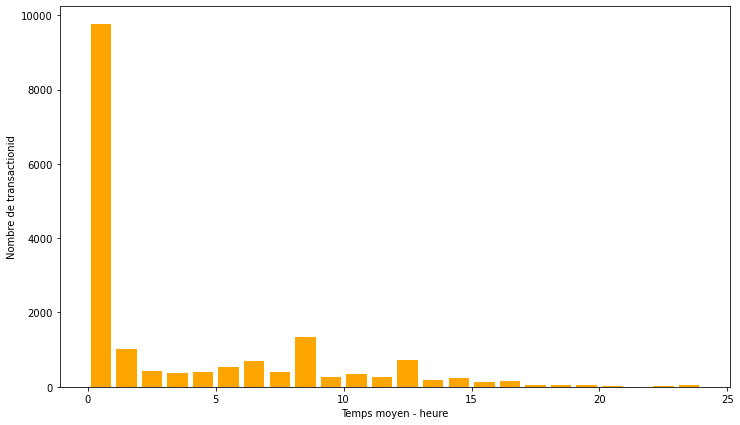

In [110]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
plt.hist(round(time_mean_transaction['mean_time_second']/3600),bins=24, rwidth=0.8, color="orange")
plt.xlabel("Temps moyen - heure")
plt.ylabel("Nombre de transactionid")
plt.show()


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb522fd3940>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb522d42370>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb522b593a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb522b2b2b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb522e46af0>,
 'means': []}

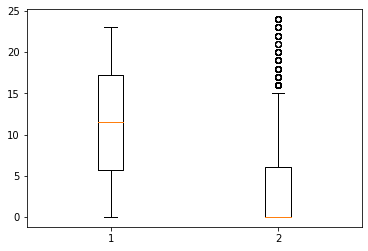

In [117]:
plt.boxplot([np.arange(0,24,1), round(time_mean_transaction['mean_time_second']/3600)])
